<a href="https://colab.research.google.com/github/vrgeo/ml-tutorials/blob/main/session_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 2: Salt classification with CNNs using Tensorflow and Keras

In this session, you will learn how to train a simple salt classifier using tensorflow.

## 1. Preparing the Datasets

In [71]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report

In [14]:
!wget https://github.com/vrgeo/ml-tutorials/blob/5c17fe8c779b0ab22243ef77753e94e923dd7deb/data/dataset_train.npz?raw=true -O dataset_train.npz
!wget https://github.com/vrgeo/ml-tutorials/blob/5c17fe8c779b0ab22243ef77753e94e923dd7deb/data/dataset_test.npz?raw=true -O dataset_test.npz

--2021-06-17 13:34:41--  https://github.com/vrgeo/ml-tutorials/blob/5c17fe8c779b0ab22243ef77753e94e923dd7deb/data/dataset_train.npz?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/vrgeo/ml-tutorials/raw/5c17fe8c779b0ab22243ef77753e94e923dd7deb/data/dataset_train.npz [following]
--2021-06-17 13:34:41--  https://github.com/vrgeo/ml-tutorials/raw/5c17fe8c779b0ab22243ef77753e94e923dd7deb/data/dataset_train.npz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vrgeo/ml-tutorials/5c17fe8c779b0ab22243ef77753e94e923dd7deb/data/dataset_train.npz [following]
--2021-06-17 13:34:42--  https://raw.githubusercontent.com/vrgeo/ml-tutorials/5c17fe8c779b0ab22243ef77753e94e923dd7deb/data/dataset_train.npz
Resolving raw.githubusercontent.com (raw.githubuserc

In [70]:
training_data = np.load("dataset_train.npz", allow_pickle=True)
training_patches = training_data["arr_0"]
training_labels = training_data["arr_1"]
print(f'Loaded {len(training_patches)} training patches and {len(training_labels)} corresponding labels')

test_data = np.load("dataset_test.npz", allow_pickle=True)
test_patches = test_data["arr_0"]
test_labels = test_data["arr_1"]
print(f'Loaded {len(test_patches)} training patches and {len(test_labels)} corresponding labels')

Loaded 3223 training patches and 3223 corresponding labels
Loaded 359 training patches and 359 corresponding labels


In [28]:
n_salt = np.count_nonzero(training_labels)
n_background = len(training_labels) - n_salt
print(f'Found {n_salt} patches containing salt and {n_background} patches not containing salt.')

Found 1084 patches containing salt and 2139 patches not containing salt.


In [42]:
def visualize_patches(patches, labels, rows, cols, colormap = 'gray'):
  fig = plt.figure(figsize=(cols*2, rows*2.2))
  for i in range(len(patches)):
    title = "Not Salt"
    if labels[i]==1:
      title = "Salt"
    plt.subplot(rows, cols, i+1)
    plt.imshow(patches[i], cmap = colormap)
    plt.axis('off')
    plt.title(title)

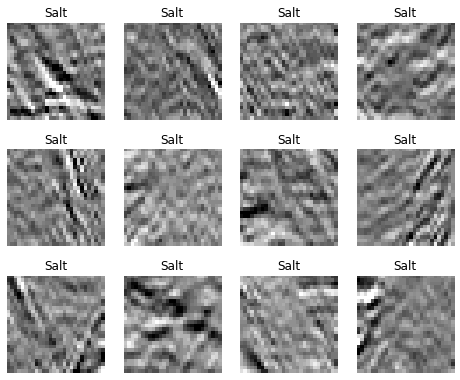

In [100]:
salt_indices = np.nonzero(training_labels)[0]
random_salt_indices = np.random.choice(salt_indices, 12, replace=False)
visualize_patches(training_patches[random_salt_indices], training_labels[random_salt_indices], 3, 4)


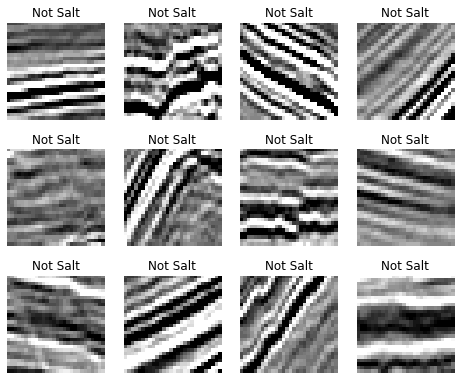

In [102]:
background_indices = np.nonzero(1-training_labels)[0]
random_background_indices = np.random.choice(background_indices, 12, replace=False)
visualize_patches(training_patches[random_background_indices], training_labels[random_background_indices], 3, 4)

In [64]:
def normalize_and_reshape_data(input_patches):
  patches = tf.keras.utils.normalize(input_patches, axis=1)
  patches = np.array(patches).reshape(-1, 28, 28, 1)
  return patches

training_patches_normalized = normalize_and_reshape_data(training_patches)
input_shape =  training_patches_normalized.shape[1:]

## 2. Defining and training the model

In [65]:
model = tf.keras.models.Sequential()  

model.add(tf.keras.layers.Conv2D(filters=6 ,kernel_size=5, strides=1, activation=tf.nn.relu, input_shape=input_shape))
model.add(tf.keras.layers.AveragePooling2D(pool_size=2,strides=2))

model.add(tf.keras.layers.Conv2D(filters=16 ,kernel_size=5, strides=1, activation=tf.nn.relu))
model.add(tf.keras.layers.AveragePooling2D(pool_size=2,strides=2))

In [66]:
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(120, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(84, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

In [69]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

model.fit(training_patches_normalized, training_labels, epochs=10)

Epoch 1/10
101/101 [==============================] - 2s 14ms/step - loss: 0.2912 - accuracy: 0.8709
Epoch 2/10
101/101 [==============================] - 1s 14ms/step - loss: 0.2958 - accuracy: 0.8740
Epoch 3/10
101/101 [==============================] - 1s 14ms/step - loss: 0.2690 - accuracy: 0.8852
Epoch 4/10
101/101 [==============================] - 1s 14ms/step - loss: 0.2568 - accuracy: 0.8880
Epoch 5/10
101/101 [==============================] - 1s 14ms/step - loss: 0.2398 - accuracy: 0.8973
Epoch 6/10
101/101 [==============================] - 1s 14ms/step - loss: 0.2276 - accuracy: 0.9066
Epoch 7/10
101/101 [==============================] - 1s 14ms/step - loss: 0.2036 - accuracy: 0.9159
Epoch 8/10
101/101 [==============================] - 1s 15ms/step - loss: 0.1996 - accuracy: 0.9159
Epoch 9/10
101/101 [==============================] - 1s 14ms/step - loss: 0.1800 - accuracy: 0.9252
Epoch 10/10
101/101 [==============================] - 1s 14ms/step - loss: 0.1813 - accura

## 3. Evaluation

In [79]:
test_patches_normalized = normalize_and_reshape_data(test_patches)

predictions = model.predict(test_patches_normalized)
prediction_labels = test_predictions.reshape(-1)
prediction_labels = (prediction_labels > 0.5).astype(np.uint8)

print(classification_report(test_labels, prediction_labels, digits=5))

              precision    recall  f1-score   support

           0    0.96748   0.95582   0.96162       249
           1    0.90265   0.92727   0.91480       110

    accuracy                        0.94708       359
   macro avg    0.93507   0.94155   0.93821       359
weighted avg    0.94762   0.94708   0.94727       359



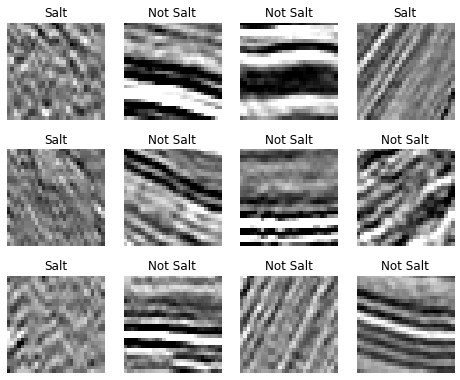

In [97]:
random_test_indices = np.random.choice(np.arange(len(test_patches)), 12, replace=False)
visualize_patches(test_patches[random_test_indices], prediction_labels[random_test_indices], 3, 4)

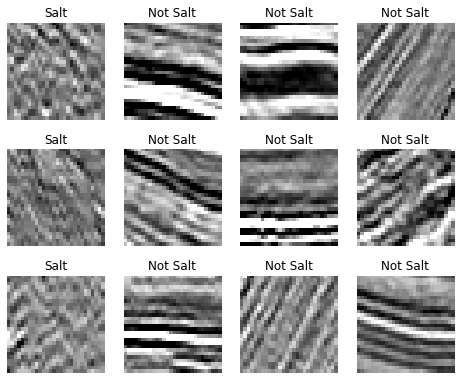

In [99]:
visualize_patches(test_patches[random_test_indices], test_labels[random_test_indices], 3, 4)

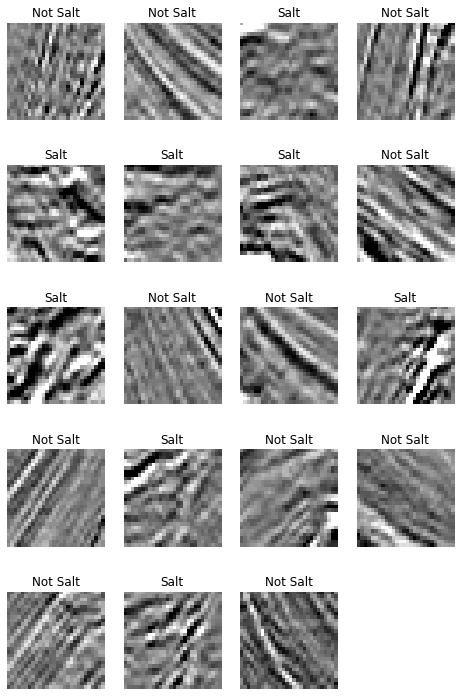

In [108]:
residuals = test_labels - prediction_labels
missclassified_indices = np.nonzero(residuals)[0]
#false_postitive_indices = np.where(residuals == 255)
#false_negative_indices = np.where(residuals == 1)

visualize_patches(test_patches[missclassified_indices], test_labels[missclassified_indices], 1+(len(missclassified_indices)/4), 4)
#visualize_patches(test_patches[false_postitive_indices], test_labels[false_postitive_indices], 3, 4)
#visualize_patches(test_patches[false_negative_indices], test_labels[false_negative_indices], 3, 4)